# Ensemble Model

* The purpose of this notebook is to combine several of the most successful pre-trained models from other experiments into an ensemble and evaluate their collective classification.

*Author: Dominik Chodounský, FIT CTU in Prague (Last edit: 05/11/21)*

In [1]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import SGD, Nadam, Adam
from tensorflow.python.client import device_lib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import cv2
import matplotlib.pyplot as plt
import time
import random
import numpy as np
import os
import sys
import shutil

## Constants and Settings
* Set variable *ROOT_DIR* to contain path to root *BI-BAP* folder.
* Set variables *TRAIN_DIR* and *TEST_DIR* to contain paths to training and test data folders (default values are meant for training on the COVIDx8B dataset).
* You may change the default parameters for the evaluation as well, their description is provided in the following cell.

In [2]:
ROOT_PATH = '../'
TRAIN_DIR = os.path.join(ROOT_PATH, 'data/COVIDx8B/train')
TEST_DIR = os.path.join(ROOT_PATH, 'data/COVIDx8B/test')

IMG_SIZE = 224   # target width and height of images that they will be resized to
BATCH_SIZE = 32  # size of generated batches of images
CHANNEL_CNT = 3  # number of channels in images (3 = RGB, 1 = Grayscale)
THRESHOLD = 0.22 # classification threshold of the individual models and the ensemble
RAND_SEED = 111  # random seed for reproducibility

# ------------------------------------------------------------------------------------------------------------------------#
np.random.seed(RAND_SEED)
tf.random.set_seed(RAND_SEED)
random.seed(RAND_SEED)
os.environ['PYTHONHASHSEED'] = str(RAND_SEED)

warnings.filterwarnings("ignore")


## File Imports
* Imports files containing helper functions and preprocessing functions.

In [3]:
from utils.utils import get_generators, get_class_weights, oversampling, plot_eval
from preprocessing.image_preprocessing import *

# individual preprocessing functions for pretrained models (applicable to transfer learning)
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_densenet
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet50
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.vgg19 import preprocess_input as preprocess_vgg19
from tensorflow.keras.applications.xception import preprocess_input as preprocess_xception

## Preprocessor definitions
* Preprocessing functions themselves are defined in *BI-BAP/src/preprocessing/image_preprocessing.py*, the following preprocessors are wrappers that allow for calling them within the Image Data Generators with necessary arguments.

In [4]:
# Performs segmentation which aims to remove section of the image with high contrast (removes diaphragm)
def preprocessor_remove_diaphragm(img, img_size=(IMG_SIZE)):
    removed = remove_diaphragm(img, img_size)[-1]
    return removed / 255

# Performs RGB variant for Histogram equalization
def preprocessor_rgb_histogram_eq(img, img_size=IMG_SIZE):
    equalized = rgb_histogram_equalization(img, img_size)[-1]
    return equalized / 255

# Performs RGB variant for Contrast limited adaptive histogram equalization (CLAHE)
def preprocessor_rgb_clahe(img, img_size=IMG_SIZE, clip_limit=3):
    equalized = rgb_clahe(img, img_size, clip_limit)[-1]
    return equalized / 255

# Default preprocessor, only performs resize and scaling
def preprocessor(img):
    new_img = cv2.resize(img.astype('uint8'), (IMG_SIZE, IMG_SIZE))
    return new_img / 255

## Ensemble Configuration
* Fill the ensemble list with sub-lists where the first element is the loaded trained base model and the second element is the specific model's preprocessing function that will be applied to images during the model's predictions.

In [6]:
ensemble = [
    [tf.keras.models.load_model(os.path.join(ROOT_PATH, 'models/CNN/cross-validation/basenet/basenet-preprocessor-Adam_0.0001-random--1.h5')), preprocessor],
    [tf.keras.models.load_model(os.path.join(ROOT_PATH, 'models/CNN/training/vgg_16/vgg_16-preprocess_input-Adam_0.0001-imagenet-fine_tuning.h5')), preprocess_vgg16],
    [tf.keras.models.load_model(os.path.join(ROOT_PATH, 'models/CNN/training/vgg_19/vgg_19-preprocess_input-Adam_0.0001-imagenet-fine_tuning.h5')), preprocess_vgg19],
    [tf.keras.models.load_model(os.path.join(ROOT_PATH, 'models/CNN/training/resnet_50/resnet_50-preprocess_input-Adam_0.0001-imagenet-fine_tuning.h5')), preprocess_resnet50],
    [tf.keras.models.load_model(os.path.join(ROOT_PATH, 'models/CNN/training/densenet_121/densenet_121-preprocess_input-Adam_0.0001-chexnet-fine_tuning.h5')), preprocess_densenet],
    [tf.keras.models.load_model(os.path.join(ROOT_PATH, 'models/CNN/training/xception/xception-preprocess_input-Adam_0.0001-imagenet-fine_tuning.h5')), preprocess_xception]   
]

* Function for calculating the predicted probabilities of one base model from the ensemble for all data in the test set (can be adapted for predictions on training set as well).

In [7]:
def base_model_predict(cnn, preprocessing_function):
    datagen_eval = ImageDataGenerator(preprocessing_function=preprocessing_function)
    train_gen, _, test_gen = get_generators(datagen_eval, TRAIN_DIR, TEST_DIR, IMG_SIZE, BATCH_SIZE, CHANNEL_CNT, False, RAND_SEED)

    y_pred_prob = cnn.predict(test_gen)
    y_pred = y_pred_prob.copy()
    y_pred[y_pred <= THRESHOLD] = 0
    y_pred[y_pred > THRESHOLD] = 1
    y_true = test_gen.classes[test_gen.index_array]
    return y_pred, y_pred_prob, y_true

* Gather predicted probabilities of all base models in the ensemble.

In [8]:
%%capture
ensemble_pred_prob = []
for cnn in ensemble:
    y_pred, y_pred_prob, y_true = base_model_predict(cnn[0], cnn[1])
    ensemble_pred_prob.append(y_pred_prob)

# calculate the mean of estimated probability per each image from all of the base models' predictions
ensemble_preds_prob = np.asarray(np.mean(np.dstack(ensemble_pred_prob), axis=2))

* Use specified classification threshold to classify the mean probabilities into the binary classes as either positive (1) or negative (0).

In [9]:
thresholded_prob = ensemble_preds_prob.copy()
thresholded_prob[thresholded_prob <= THRESHOLD] = 0
thresholded_prob[thresholded_prob > THRESHOLD] = 1

* Calculate evaluation metrics.

In [10]:
print(classification_report(y_true, thresholded_prob))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       200
           1       1.00      0.98      0.99       200

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



In [11]:
tn, fp, fn, tp = confusion_matrix(y_true, thresholded_prob).ravel()

# Binary Accuracy, Sensitivity (TPR), Specificity (TNR), Positive Predictive Value (PPV)
(tp+tn)/(tp+tn+fp+fn), tp/(tp+fn), tn/(tn+fp), tp/(tp+fp)

(0.9925, 0.985, 1.0, 1.0)

* Calculate the optimal threshold for given data.

* *(Note: For COVIDx8B training set, the optimal classification threshold was calculated to be 0.32 and for COVIDx3 it was 0.03)*


In [ ]:
fpr, tpr, thresholds = roc_curve(y_true,ensemble_preds_prob)
print(f'Optimal threhold which maximizes TPR and minimizes FPR is: {thresholds[np.argmax(tpr - fpr)]:.2f}')

Optimal threhold which maximizes TPR and minimizes FPR is: 0.32


* Calculate the combined optimal threshold for both of the dataset versions by taking their weighted average (COVIDx8B has double the weight of COVIDx3).

In [12]:
COVIDx8B_threshold = 0.32
COVIDx3_threshold = 0.03
print(f'The combined optimal threshold for both dataset versions is: {np.average([COVIDx8B_threshold, COVIDx3_threshold], weights=[2, 1]):.2f}')

The combined optimal threshold for both dataset versions is: 0.22


* Plot confusion matrix and ROC curve.

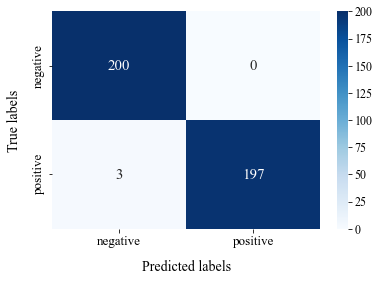

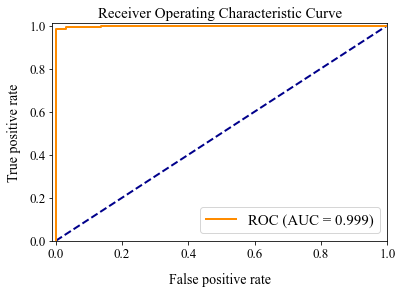

In [13]:
plot_eval(y_true, ensemble_preds_prob, thresholded_prob)